In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np
import numpy.random as rd
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import random
import torch.utils.data as data_utils
from sklearn.decomposition import PCA

In [3]:
#load stimuli
%cd /content/gdrive/My Drive/RNN/
stim_all= torch.tensor(np.loadtxt("2backRNN_trainStim.txt")).float()
targets_all= torch.tensor(np.loadtxt("2backRNN_trainTarget.txt")).float()

/content/gdrive/My Drive/RNN


In [4]:

#Build RNN
dl = 2
class RNN(nn.Module):
    def __init__(self, n_neurons):
        super(RNN, self).__init__()
        self.n_neurons = n_neurons # number of neurons
        self.Wrec = nn.Parameter(torch.randn(n_neurons, n_neurons) / np.sqrt(n_neurons)) # recurrent weights
        self.out = nn.Linear(n_neurons, 1) # output weights
        self.inp_layer = nn.Linear(6, n_neurons) # input layer to RNN layer
        
    def step(self, input_ext, hidden, stim_on):
        input_mat = torch.zeros(input_ext.size(0), 6) #20 is batch size
       
        for k in range(input_ext.size(0)):
            if stim_on == 1:
                input_mat[k,int(input_ext[k,0])] = 1  #activate the stimulus unit
        hidden = torch.relu(torch.matmul(self.Wrec, hidden.unsqueeze(-1)).squeeze() + self.inp_layer(input_mat)) #+ self.inp(input_ext))
        # hidden = torch.relu(torch.matmul(self.Wrec, hidden.unsqueeze(-1)).squeeze() + self.inp_layer(input_mat)) #+ self.inp(input_ext))
        output = self.out(hidden)
        return output, hidden

    def forward(self, inputs):
        """
        Run the RNN with input timecourses
        """    
        # Initialize network state
        hidden = torch.zeros(inputs.size(0), self.n_neurons)
        output = torch.zeros(inputs.size(0), inputs.size(1))
        hidden_all = torch.zeros(inputs.size(1),inputs.size(0), self.n_neurons)
        # Run the input through the network
        for i in range(inputs.size(1)): #loop through all timepoints
            stim_on = 0
            if (i+1)%(dl+1)==1: 
                stim_on = 1 
            output_i, hidden = self.step(inputs[:, i].unsqueeze(-1), hidden, stim_on)
            hidden_all[i,:,:] = hidden
            output[:,i] = output_i.squeeze()  #record ALL outputs
        return hidden_all, output.squeeze(),

In [5]:
n_neurons = 8
model = RNN(n_neurons)
learning_rate = 3e-3 # 1e-5#
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # it was model before!!!!
n_stim = 20
n_timestep = n_stim*(dl+1)-dl

# Squared error loss function (MSE)
def loss_fn(outputs, targets): # tasks unused
    acc = torch.zeros(outputs.size(0))
    total_err = torch.zeros(1)
    resp_tp = np.arange(2*(dl+1),n_timestep, dl+1)
    n_resp = n_stim - 2

    for i in range(outputs.size(0)): #batch
        batch_err = torch.zeros(1)
        batch_acc = 0

        for j in resp_tp: #timepoints
            batch_err += (targets[i,j] - outputs[i,j])**2/n_resp
            err = (targets[i,j] - outputs[i,j]).detach().numpy()
            if np.absolute(err) < 0.5:
                batch_acc += 1/n_resp
        total_err += batch_err
        acc[i] = batch_acc
    return total_err, acc

In [9]:
# Run LSTM

n_iter = 5000 # iterations of SGD, 500
batch_size = 20
track_loss = np.zeros(n_iter)
np.random.seed()
n_sequence = 200

t = 0
# Loop over iterations
for i in range(n_iter):
    if (i + 1) %  250 == 0: # print progress every 100 iterations
        print('%.2f%% iterations of Adam completed...loss = %.2f' % (100* (i + 1) / n_iter, loss))
    input_mat = torch.zeros(n_timestep,batch_size, 10)

    batch_idx = np.random.choice(n_sequence, batch_size)
    stim, targets = stim_all[batch_idx,:], targets_all[batch_idx,:]
    # Run model 
    hidden, outputs = model.forward(stim)
    # Compute loss
    loss, acc = loss_fn(outputs, targets)
    track_loss[t] = loss 
    # Compute gradients
    optimizer.zero_grad()
    loss.backward()
    # Update weights
    optimizer.step()
    t += 1

10.00% iterations of Adam completed...loss = 1.98
20.00% iterations of Adam completed...loss = 1.10
30.00% iterations of Adam completed...loss = 0.25
40.00% iterations of Adam completed...loss = 0.07
50.00% iterations of Adam completed...loss = 0.03
60.00% iterations of Adam completed...loss = 0.02
70.00% iterations of Adam completed...loss = 0.02
80.00% iterations of Adam completed...loss = 0.02
90.00% iterations of Adam completed...loss = 0.01
100.00% iterations of Adam completed...loss = 0.01


In [ ]:
print(acc)
sum(acc)/20
plt.plot(track_loss)

In [13]:
#test network
n_timestep = n_stim*(dl+1)-dl
n_hidden = 8
n_sequence = 200

stim = torch.tensor(np.loadtxt("2B_test_200_stim.txt")).float() #1 is 2back
targets = torch.tensor(np.loadtxt("2B_test_200_targ.txt")).float()
stim, targets = stim_all, targets_all
batch_size = n_sequence #50
input_mat = torch.zeros(n_timestep, batch_size, 6)
#batch_idx = np.random.choice(n_sequence, batch_size)
#stim_00, targets_00 = stim_0[batch_idx,:], targets_0[batch_idx,:] # 2back #############
#stim_01, targets_01 = stim_1[batch_idx,:], targets_1[batch_idx,:]########

for i in range(batch_size):
    for j in range(n_timestep):
        if (j+1)%3==1:
            input_mat[j,i,int(stim[i,j])] = 1  #activate the stimulus unit
hidden, outputs  = model.forward(stim)
loss, acc = loss_fn(outputs, targets)
print(loss)
# print(acc)
print(sum(acc)/200)

tensor([0.0795], grad_fn=<AddBackward0>)
tensor(1.)


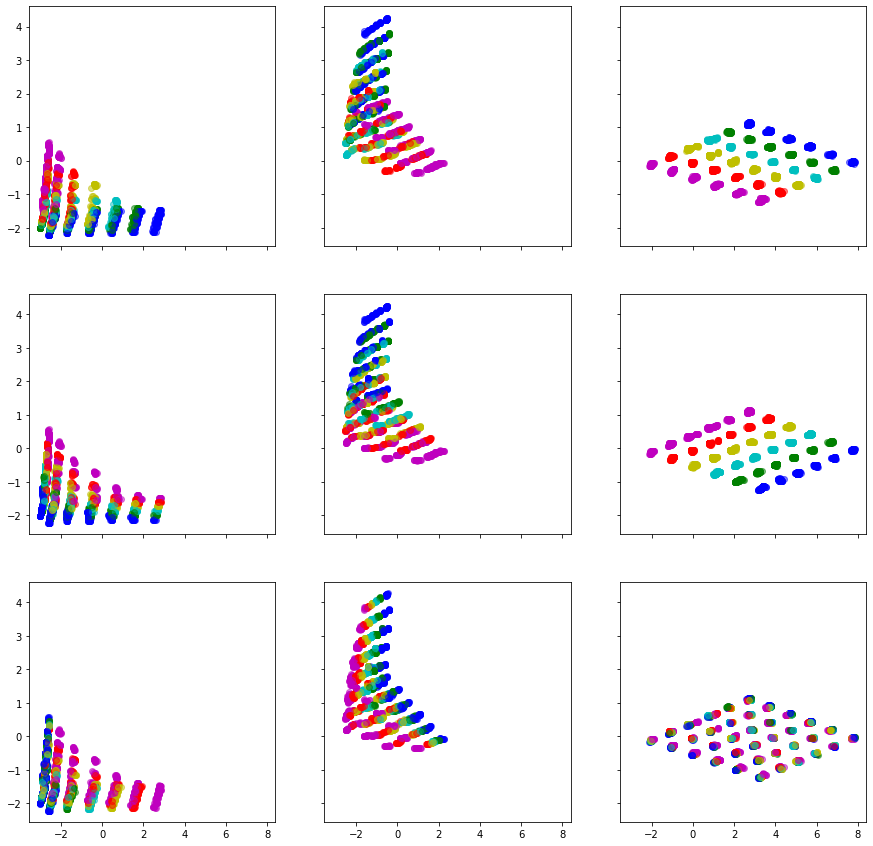

In [12]:
#######################   PCA of hidden layer activations (colored by stimulus n)  ###################
n_hidden = 8
fig, axs = plt.subplots(3, 3, figsize=(3*5, 3*5), sharex=True, sharey=True) #2 rows and 3 columns: 2, 3, figsize=(3*5, 2*5)

# Set up PCA
pca = PCA(n_components=2) # reduce dimensionality to 2

# Choose stimuli whose representations to plot and colors to plot them with
plot_digits = [0,1,2,3,4,5]
plot_colors = ['r', 'b', 'g','y', 'm', 'c']

# Do PCA on activations, and plot the dimensionality-reduced activations
hid_2d = np.reshape(hidden.transpose(dim0=1,dim1=0).detach().numpy(), (-1, n_hidden))
stim_2d = np.reshape(stim.detach().numpy(),(-1))
pc_activity = pca.fit_transform(hid_2d) 

for t_move in range(9):#np.array([0,1,2,3]):##([0,1,2,3]):#([0,1,2,3]):#([4,5,6,7]):#

    tp0 = np.arange(6,51,3) + t_move 
    for bnum in range(batch_size):
        if bnum == 0:
            tps = tp0 #6 is third stimulus, 54 is (n-2)stimulus
        else:
            tps = np.concatenate((tps, tp0 + 58*bnum))

    for indx in tps:
        label = stim_2d[indx-t_move]
        for digit, color in zip(plot_digits, plot_colors):
            if label == digit:
                x, y = pc_activity[indx, 0], pc_activity[indx, 1]
                if t_move < 3:
                    axs[0,t_move].plot(x, y, 'o', color=color, alpha=0.5)
                elif t_move < 6:
                    axs[1,t_move-3].plot(x, y, 'o', color=color, alpha=0.5)
                else:
                    axs[2,t_move-6].plot(x, y, 'o', color=color, alpha=0.5)